In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

!pip install tensorflow-addons
import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D



print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.15.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_dir = "drive/MyDrive/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = base_dir

#if os.path.exists(work_dir):
#    remove_tree(work_dir)


#os.mkdir(work_dir)
#copy_tree(train_dir, work_dir)
#copy_tree(test_dir, work_dir)
#print("Working Directory Contents:", os.listdir(work_dir))

In [ ]:
WORK_DIR = '/content/drive/MyDrive/Alzheimer_s Dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [ ]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=work_dir, target_size=DIM, batch_size=6500, shuffle=False)

Found 950 images belonging to 1 classes.


In [ ]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """

    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))

    # get a batch of images
    x,y = generator.next()

    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))

    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))



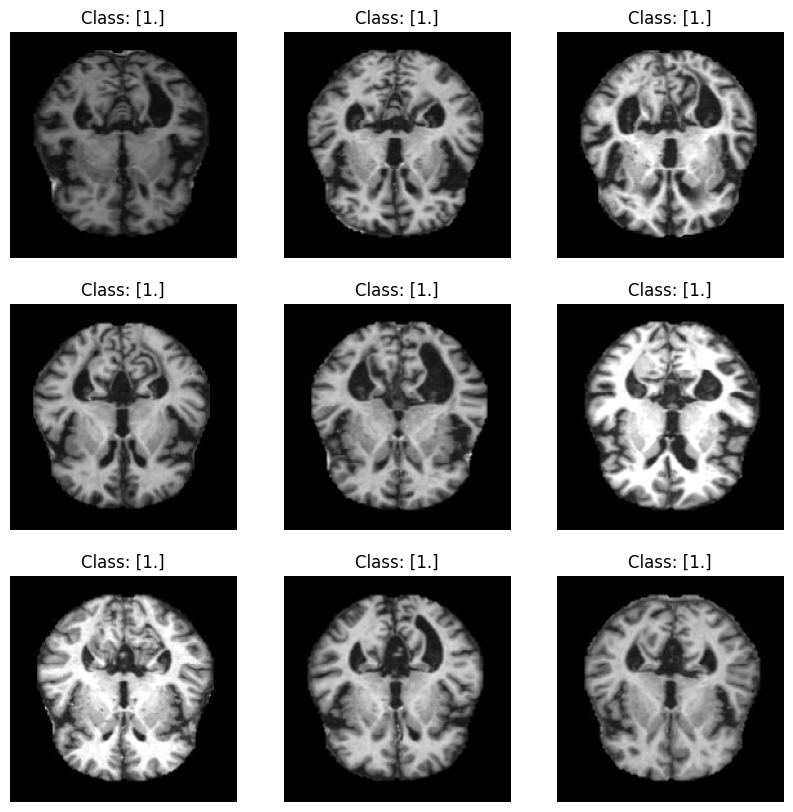

In [ ]:
import matplotlib.pyplot as plt

def show_images(generator, num_images=9):
    # Get a batch of images and labels from the generator
    batch = next(generator)
    images, labels = batch

    # Plot the images
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
        plt.title("Class: {}".format(labels[i]))
    plt.show()

# Call the function to display images
show_images(train_data_gen)


**Convolution Neural Network**

In [ ]:
train =tf.keras.preprocessing.image_dataset_from_directory(train_dir,validation_split=.2,subset='training',
                                                           seed=1337,image_size=IMAGE_SIZE,batch_size=64)

validatioin =tf.keras.preprocessing.image_dataset_from_directory(train_dir,validation_split=.2,subset='validation',
                                                                 seed=1337,image_size=IMAGE_SIZE,batch_size=64)

Found 950 files belonging to 3 classes.
Using 760 files for training.
Found 950 files belonging to 3 classes.
Using 190 files for validation.


In [ ]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
num_classes=len(class_names)
train.class_names=class_names
validatioin.class_names=class_names

In [ ]:
from tensorflow.data.experimental import AUTOTUNE
def one_hot_label(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

train=train.map(one_hot_label, num_parallel_calls=AUTOTUNE)
validatioin=validatioin.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [ ]:
train= train.cache().prefetch(buffer_size=AUTOTUNE)
validatioin = validatioin.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(4, activation='softmax')
    ])

    return model

In [ ]:
model = build_model()
METRICS = [tf.keras.metrics.AUC(name='auc')]
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [ ]:
history = model.fit(
   train,validation_data=validatioin,callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],epochs=1
)

12/12 [==============================] - ETA: 0s - loss: 1.5676 - auc: 0.6611

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 78s 6s/step - loss: 1.5676 - auc: 0.6611 - val_loss: 2.5282 - val_auc: 0.7860 - lr: 0.0100


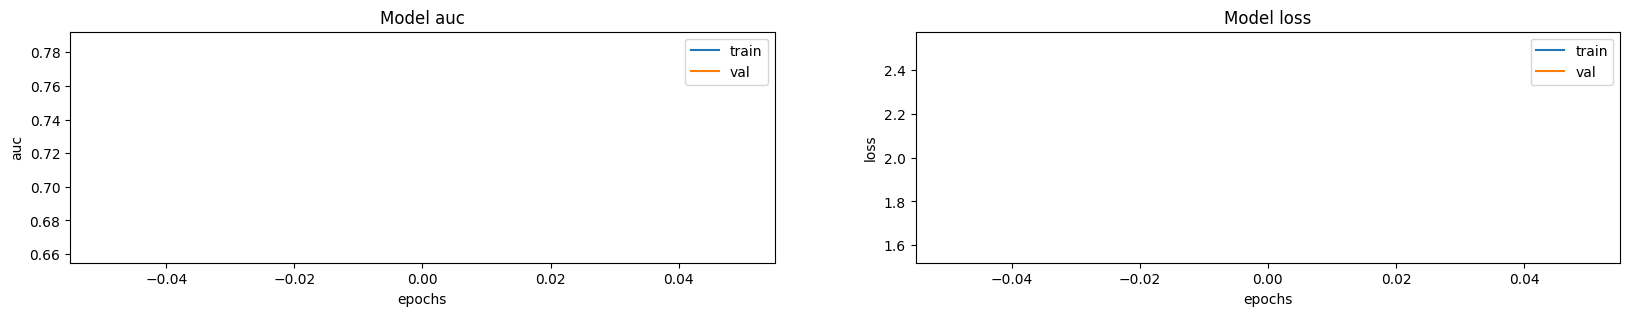

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Alzheimer_s Dataset/test",
    image_size=IMAGE_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 1 classes.


In [ ]:
pred=model.evaluate(test_ds)
pred

40/40 [==============================] - 126s 2s/step - loss: 7.4276 - auc: 0.3333


[7.427605152130127, 0.3333333134651184]

In [ ]:
model.save('Alzheimer_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
